# Cell 1: Setup Dependencies

In [2]:
# ============================================================================
# YOLOv8 Custom Pothole Detection - Complete Google Colab Notebook
# Dataset: Pothole Detection (1,450 images, 1 class)
# Road safety applications
# ============================================================================

print("Setting up YOLOv8 Pothole Detection Environment")
print("=" * 55)

# Install required packages
!pip install ultralytics -q
!pip install roboflow -q

# Import libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os
import glob
import yaml
import random
from pathlib import Path
from ultralytics import YOLO
import cv2
from google.colab import drive, files
import zipfile
import numpy as np
from scipy.optimize import linear_sum_assignment

Setting up YOLOv8 Pothole Detection Environment


# CELL 2: Mount Google Drive and Setup Paths

In [6]:
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Dataset paths - Set the path of root-directory of dataset
DATASET_ROOT = '/content/drive/MyDrive/yolov8/datasets/potholesdetection-2'
print(f"Dataset path: {DATASET_ROOT}")

# Check if dataset exists
if os.path.exists(DATASET_ROOT):
    print("Dataset found!")
else:
    print("Dataset not found. Please check the path or upload your dataset.")
    print("Expected structure:")
    print("potholesdetection-2/")  # Changed name
    print("   ├──  data.yaml")
    print("   ├──  train/")
    print("   │   ├──  images/")
    print("   │   └──  labels/")
    print("   ├──  valid/")
    print("   └──  test/")


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path: /content/drive/MyDrive/yolov8/datasets/potholesdetection-2
Dataset found!


In [ ]:
# import os

# len(os.listdir('/content/drive/MyDrive/yolov8/datasets/potholesdetection-2/valid/images'))

779

# CELL 3: Dataset Analysis and Exploration

In [8]:
def analyze_dataset():
    """Comprehensive dataset analysis"""
    print("\nDATASET ANALYSIS")
    print("=" * 30)

    # Read configuration
    data_yaml_path = f'{DATASET_ROOT}/data.yaml'
    if not os.path.exists(data_yaml_path):
        print("data.yaml not found!")
        return None

    with open(data_yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    print(f"Dataset Configuration:")
    print(f"   => Classes: {config['nc']} class (Pothole)")  # Changed from "digits"
    print(f"   => Names: {config['names']}")

    # Count images and labels
    splits = ['train', 'valid', 'test']
    total_images = 0
    split_info = {}

    for split in splits:
        images_dir = f'{DATASET_ROOT}/{split}/images'
        labels_dir = f'{DATASET_ROOT}/{split}/labels'

        if os.path.exists(images_dir):
            images = glob.glob(f'{images_dir}/*.jpg')
            labels = glob.glob(f'{labels_dir}/*.txt')
            print(f"   => {split.title()} set: {len(images)} images, {len(labels)} labels")
            total_images += len(images)
            split_info[split] = {'images': len(images), 'labels': len(labels)}
        else:
            print(f"   => {split.title()} set: Not found")
            split_info[split] = {'images': 0, 'labels': 0}

    print(f"   => Total: {total_images} images")

    # Analyze class distribution - UPDATED FOR SINGLE CLASS
    print(f"\nPothole Distribution (Training Set):")
    pothole_count = 0
    total_label_files = 0

    train_labels_dir = f'{DATASET_ROOT}/train/labels'
    if os.path.exists(train_labels_dir):
        for label_file in glob.glob(f'{train_labels_dir}/*.txt'):
            total_label_files += 1
            with open(label_file, 'r') as f:
                lines = f.readlines()
                pothole_count += len([line for line in lines if line.strip()])

    print(f"   => Total potholes annotated: {pothole_count}")
    print(f"   => Label files: {total_label_files}")
    if total_label_files > 0:
        print(f"   => Average potholes per image: {pothole_count/total_label_files:.2f}")

    # Visual bar
    bar = "=" * (pothole_count // 100) if pothole_count > 0 else ""
    print(f"   => Visual: {bar}")

    return config, split_info, pothole_count

# Run dataset analysis
if os.path.exists(DATASET_ROOT):
    config, split_info, pothole_count = analyze_dataset()


DATASET ANALYSIS
Dataset Configuration:
   => Classes: 1 class (Pothole)
   => Names: ['potholes']
   => Train set: 1266 images, 1266 labels
   => Valid set: 121 images, 121 labels
   => Test set: 61 images, 61 labels
   => Total: 1448 images

Pothole Distribution (Training Set):
   => Total potholes annotated: 6093
   => Label files: 1266
   => Average potholes per image: 4.81
   => Visual: ============================================================


## CELL 3.5: Clean up images without labels

In [31]:
# def cleanup_unlabeled_images():
#     """Remove images that don't have corresponding label files"""
#     print("\nCHECKING FOR UNLABELED IMAGES")
#     print("=" * 40)

#     splits = ['train', 'valid', 'test']
#     total_removed = 0

#     for split in splits:
#         images_dir = f'{DATASET_ROOT}/{split}/images'
#         labels_dir = f'{DATASET_ROOT}/{split}/labels'

#         if not os.path.exists(images_dir):
#             continue

#         # Get all images and labels
#         image_files = glob.glob(f'{images_dir}/*.jpg')

#         # Track images without labels
#         images_without_labels = []

#         for img_path in image_files:
#             # Get corresponding label path
#             img_name = os.path.basename(img_path)
#             label_name = img_name.replace('.jpg', '.txt')
#             label_path = f'{labels_dir}/{label_name}'

#             if not os.path.exists(label_path):
#                 images_without_labels.append(img_path)

#         if images_without_labels:
#             print(f"\n {split.upper()} set:")
#             print(f"   => Found {len(images_without_labels)} images without labels")

#             # Show first few examples
#             print(f"   => Examples:")
#             for img in images_without_labels[:3]:
#                 print(f"     - {os.path.basename(img)}")
#             if len(images_without_labels) > 3:
#                 print(f"     ... and {len(images_without_labels)-3} more")

#             # Ask for confirmation before deletion
#             response = input(f"\nDelete these {len(images_without_labels)} unlabeled images from {split}? (yes/no): ")

#             if response.lower() == 'yes':
#                 for img_path in images_without_labels:
#                     os.remove(img_path)
#                     total_removed += 1
#                 print(f"   Removed {len(images_without_labels)} images")
#             else:
#                 print(f"   Skipped deletion")
#         else:
#             print(f"\n{split.upper()} set: All images have labels")

#     print(f"\nCleanup complete! Removed {total_removed} total images")

#     # Re-run analysis to confirm
#     print("\nUPDATED DATASET STATS:")
#     print("-" * 30)
#     for split in splits:
#         images_dir = f'{DATASET_ROOT}/{split}/images'
#         labels_dir = f'{DATASET_ROOT}/{split}/labels'

#         if os.path.exists(images_dir):
#             images = glob.glob(f'{images_dir}/*.jpg')
#             labels = glob.glob(f'{labels_dir}/*.txt')
#             print(f"   => {split.title()}: {len(images)} images, {len(labels)} labels " if len(images)==len(labels) else f"   => {split.title()}: {len(images)} images, {len(labels)} labels")

# # Run cleanup
# cleanup_unlabeled_images()

# CELL 4: Visualize Samples of Dataset


SAMPLE DATA VISUALIZATION
   Sample 1: 14 potholes detected
   Sample 2: 1 potholes detected
   Sample 3: 7 potholes detected


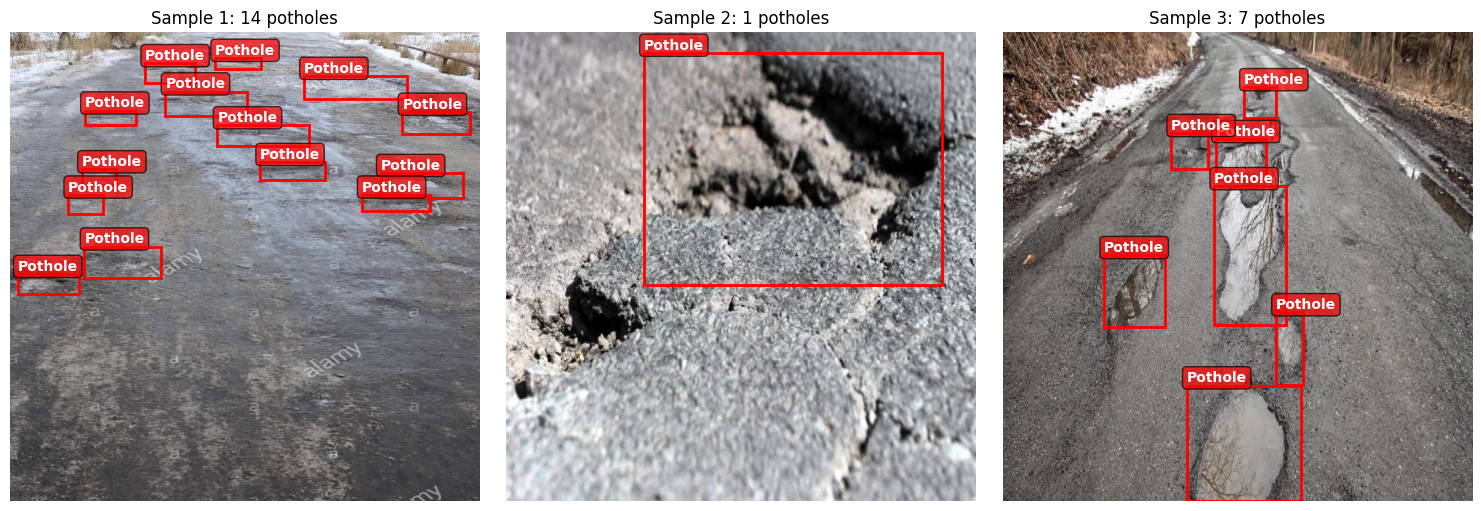

In [9]:
def load_yolo_labels(label_path):
    """Load YOLO format labels"""
    labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])  # Will always be 0 for potholes
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    labels.append({
                        'class_id': class_id,
                        'label': 'pothole',  # Changed from 'digit'
                        'x_center': x_center,
                        'y_center': y_center,
                        'width': width,
                        'height': height
                    })
    return labels

def visualize_sample_data(num_samples=3):
    """Visualize sample images with annotations"""
    print(f"\nSAMPLE DATA VISUALIZATION")
    print("=" * 35)

    # Get training images
    train_images = glob.glob(f'{DATASET_ROOT}/train/images/*.jpg')
    if not train_images:
        print("No training images found!")
        return

    # Select random samples
    samples = random.sample(train_images, min(num_samples, len(train_images)))

    fig, axes = plt.subplots(1, len(samples), figsize=(5*len(samples), 5))
    if len(samples) == 1:
        axes = [axes]

    for idx, image_path in enumerate(samples):
        # Load image
        image = Image.open(image_path)
        img_width, img_height = image.size

        # Load labels
        label_path = image_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
        labels = load_yolo_labels(label_path)

        # Display image - removed cmap='gray' for color images
        axes[idx].imshow(image)
        axes[idx].set_title(f'Sample {idx+1}: {len(labels)} potholes')  # Changed from 'digits'

        # Draw bounding boxes - single color for single class
        color = 'red'  # Single color for all potholes

        for label in labels:
            # Convert YOLO to pixel coordinates
            x_center = label['x_center'] * img_width
            y_center = label['y_center'] * img_height
            width = label['width'] * img_width
            height = label['height'] * img_height

            x1 = x_center - width / 2
            y1 = y_center - height / 2

            # Draw rectangle
            rect = patches.Rectangle((x1, y1), width, height,
                                   linewidth=2, edgecolor=color, facecolor='none')
            axes[idx].add_patch(rect)

            # Add label
            axes[idx].text(x1, y1-5, 'Pothole',
                          bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                          fontsize=10, color='white', weight='bold')

        axes[idx].axis('off')
        print(f"   Sample {idx+1}: {len(labels)} potholes detected")

    plt.tight_layout()
    plt.show()

# Visualize samples
if os.path.exists(DATASET_ROOT):
    visualize_sample_data(3)

# CELL 5: Fix Data Configuration for Training

In [10]:
def setup_training_config():
    """Fix data.yaml for Colab training"""
    print(f"\nSETTING UP TRAINING CONFIGURATION")
    print("=" * 40)

    # Read original config
    with open(f'{DATASET_ROOT}/data.yaml', 'r') as f:
        config = yaml.safe_load(f)

    # Fix paths for Colab
    config['train'] = f'{DATASET_ROOT}/train/images'
    config['val'] = f'{DATASET_ROOT}/valid/images'
    config['test'] = f'{DATASET_ROOT}/test/images'

    # Save updated config
    updated_config_path = f'{DATASET_ROOT}/data_colab.yaml'
    with open(updated_config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"Updated configuration saved to: data_colab.yaml")
    print(f"Training data: {config['train']}")
    print(f"Validation data: {config['val']}")
    print(f"Test data: {config['test']}")

    return updated_config_path

# Setup training config
if os.path.exists(DATASET_ROOT):
    training_config_path = setup_training_config()



SETTING UP TRAINING CONFIGURATION
Updated configuration saved to: data_colab.yaml
Training data: /content/drive/MyDrive/yolov8/datasets/potholesdetection-2/train/images
Validation data: /content/drive/MyDrive/yolov8/datasets/potholesdetection-2/valid/images
Test data: /content/drive/MyDrive/yolov8/datasets/potholesdetection-2/test/images


# CELL 6: Model Training with Google Drive Save

In [11]:
# Set path for saving model weights
MODELS_SAVE_DIR = '/content/drive/MyDrive/yolov8/model/pothole_detector'

def train_pothole_detector(epochs=30, model_size='n', batch_size=16, save_to_drive=True):
    """Train YOLOv8 on pothole detection dataset"""
    print(f"\nTRAINING YOLO{model_size.upper()} POTHOLE DETECTOR")
    print("=" * 45)

    # Create save directory if it doesn't exist
    if save_to_drive:
        Path(MODELS_SAVE_DIR).mkdir(parents=True, exist_ok=True)
        print(f"Models will be saved to Google Drive: {MODELS_SAVE_DIR}")

    # Load model
    model = YOLO(f'yolov8{model_size}.pt')
    print(f"Loaded YOLOv8{model_size} model")

    # Training parameters
    print(f"Training Configuration:")
    print(f"   => Model: YOLOv8{model_size}")
    print(f"   => Dataset: Pothole Detection (1,450 images)")  # UPDATED
    print(f"   => Classes: 1 (Pothole)")
    print(f"   => Epochs: {epochs}")
    print(f"   => Batch size: {batch_size}")
    print(f"   => Image size: 640")
    print(f"   => Device: {'GPU' if os.path.exists('/dev/nvidia0') else 'CPU'}")
    if save_to_drive:
        print(f"   => Save location: Google Drive")
    else:
        print(f"   => Save location: Local (runs/ directory)")

    # Start training
    print(f"\nStarting training...")

    # Set Training Parameters
    if save_to_drive:
        results = model.train(
            data=training_config_path,
            epochs=epochs,
            imgsz=640,
            batch=batch_size,
            name=f'pothole_detector_v8{model_size}',
            project=MODELS_SAVE_DIR,
            patience=10,  # Reduced patience for smaller dataset
            save=True,
            plots=True,
            device=0 if os.path.exists('/dev/nvidia0') else 'cpu',
            exist_ok=True
        )
        save_location = f"{MODELS_SAVE_DIR}/pothole_detector_v8{model_size}"
    else:
        # Original training (saves to runs/ directory)
        results = model.train(
            data=training_config_path,
            epochs=epochs,
            imgsz=640,
            batch=batch_size,
            name=f'pothole_detector_v8{model_size}',
            patience=10,
            save=True,
            plots=True,
            device=0 if os.path.exists('/dev/nvidia0') else 'cpu'
        )
        save_location = f"runs/detect/pothole_detector_v8{model_size}"

    print(f"Training completed!")
    print(f"Results saved to: {save_location}")

    # Return both model and the save path for later use
    best_model_path = f"{save_location}/weights/best.pt"
    return model, results, best_model_path

# Training options - Choose one!
print(f"\nTRAINING OPTIONS FOR POTHOLE DETECTION")
print("=" * 40)
print("Dataset: 1,450 images")
print("Choose your training approach:")
print("1. Quick demo (15 epochs) - ~8-10 minutes")
print("2. Standard training (25 epochs) - ~12-15 minutes [RECOMMENDED]")
print("3. Full training (40 epochs) - ~20-25 minutes")
print("4. Skip training - use pretrained (won't detect potholes!)")
print(f"\nModels will be saved to: {MODELS_SAVE_DIR}")

# RECOMMENDED CONFIGURATION FOR CLASSROOM DEMO:
# With 1,450 images, YOLOv8n with 25 epochs is perfect for demo

# Option 1: Quick demo (8-10 minutes)
# model, results, best_model_path = train_pothole_detector(epochs=15, model_size='n', batch_size=16)

# # Option 2: RECOMMENDED - Perfect for classroom demo
model, results, best_model_path = train_pothole_detector(epochs=35, model_size='n', batch_size=16)

# Option 3: Best accuracy (if you have time)
# model, results, best_model_path = train_pothole_detector(epochs=30, model_size='s', batch_size=16)

# Option 4: Skip training (NOT recommended for custom dataset)
# model = YOLO('yolov8n.pt')
# best_model_path = 'yolov8n.pt'
# print("Loaded pretrained YOLOv8n - won't work for potholes!")

# Display final model path for easy reference
if 'best_model_path' in locals() and best_model_path != 'yolov8n.pt':
    print(f"\nTRAINED MODEL LOCATION:")
    print(f"Best weights: {best_model_path}")
    print(f"Use this path in your inference cells!")

print(f"\nTraining setup complete!")


TRAINING OPTIONS FOR POTHOLE DETECTION
Dataset: 1,450 images
Choose your training approach:
1. Quick demo (15 epochs) - ~8-10 minutes
2. Standard training (25 epochs) - ~12-15 minutes [RECOMMENDED]
3. Full training (40 epochs) - ~20-25 minutes
4. Skip training - use pretrained (won't detect potholes!)

Models will be saved to: /content/drive/MyDrive/yolov8/model/pothole_detector

TRAINING YOLON POTHOLE DETECTOR
Models will be saved to Google Drive: /content/drive/MyDrive/yolov8/model/pothole_detector


Loaded YOLOv8n model
Training Configuration:
   => Model: YOLOv8n
   => Dataset: Pothole Detection (1,450 images)
   => Classes: 1 (Pothole)
   => Epochs: 35
   => Batch size: 16
   => Image size: 640
   => Device: GPU
   => Save location: Google Drive

Starting training...
Ultralytics 8.3.181 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolov8/datasets/potholesdetection-2/data_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kob

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.1±0.1 MB/s, size: 64.9 KB)


train: Scanning /content/drive/MyDrive/yolov8/datasets/potholesdetection-2/train/labels.cache... 1266 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1266/1266 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.1±0.1 MB/s, size: 67.9 KB)


val: Scanning /content/drive/MyDrive/yolov8/datasets/potholesdetection-2/valid/labels.cache... 121 images, 0 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      2.22G      1.978      2.323      1.671         13        640: 100%|██████████| 80/80 [08:24<00:00,  6.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        121        661      0.366      0.228        0.2     0.0679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35       2.6G      1.974      1.868      1.641         16        640: 100%|██████████| 80/80 [00:25<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        121        661      0.468       0.39      0.383      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35       2.6G      1.972      1.776      1.673          4        640: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        121        661      0.442      0.315      0.307     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35       2.6G      1.954      1.721      1.666         12        640: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        121        661      0.571      0.429       0.43      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      2.61G      1.955      1.663      1.649         21        640: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        121        661      0.538      0.471      0.464      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      2.63G      1.918      1.596      1.621         31        640: 100%|██████████| 80/80 [00:25<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        121        661      0.495      0.452      0.457      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      2.65G        1.9      1.558      1.611         20        640: 100%|██████████| 80/80 [00:25<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        121        661      0.575      0.496      0.514      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      2.65G      1.891      1.522      1.609          6        640: 100%|██████████| 80/80 [00:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        121        661      0.572       0.49      0.506       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      2.65G      1.854      1.465      1.586         11        640: 100%|██████████| 80/80 [00:24<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        121        661      0.527      0.487      0.473      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      2.65G      1.822      1.428      1.552          6        640: 100%|██████████| 80/80 [00:23<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        121        661      0.543      0.525      0.521      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      2.65G      1.806      1.411      1.551         13        640: 100%|██████████| 80/80 [00:24<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        121        661      0.523      0.425      0.454      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      2.66G      1.804      1.358      1.539          5        640: 100%|██████████| 80/80 [00:24<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        121        661       0.61      0.489      0.542      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      2.69G      1.777      1.335      1.537         14        640: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        121        661      0.602      0.516      0.533      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      2.69G      1.761      1.305      1.515         16        640: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        121        661      0.628      0.468      0.523      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      2.69G      1.753      1.301      1.521         11        640: 100%|██████████| 80/80 [00:25<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        121        661      0.587      0.551       0.56      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      2.69G      1.724      1.268      1.488          9        640: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        121        661      0.568      0.517      0.526       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      2.85G      1.721      1.246      1.494         31        640: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        121        661        0.6      0.499      0.536      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      2.85G      1.695      1.217      1.473         11        640: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        121        661      0.583       0.56      0.591      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      2.85G      1.686      1.198      1.466          5        640: 100%|██████████| 80/80 [00:25<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        121        661      0.628       0.53      0.571      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      2.86G      1.633       1.15      1.434          3        640: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        121        661      0.587      0.538      0.558       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      2.86G      1.627      1.128      1.436         25        640: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        121        661      0.577      0.543      0.561      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      3.03G       1.62      1.136      1.429          8        640: 100%|██████████| 80/80 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        121        661      0.611      0.548      0.589      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      3.03G        1.6      1.076      1.405         11        640: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        121        661      0.613      0.539       0.58      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      3.03G        1.6      1.083      1.408         35        640: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        121        661      0.595      0.523      0.569      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      3.03G      1.569      1.074      1.391         33        640: 100%|██████████| 80/80 [00:26<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        121        661      0.611      0.502      0.541      0.206


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      3.03G      1.581      1.019      1.439          2        640: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        121        661      0.669      0.519      0.584       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      3.03G      1.522     0.9552      1.376          7        640: 100%|██████████| 80/80 [00:24<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        121        661      0.585      0.586        0.6      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      3.03G      1.492     0.9163      1.366         11        640: 100%|██████████| 80/80 [00:24<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        121        661      0.615      0.562      0.587      0.215
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 18, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



28 epochs completed in 0.348 hours.
Optimizer stripped from /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


                   all        121        661      0.583       0.56      0.591      0.232
Speed: 0.4ms preprocess, 4.5ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n
Training completed!
Results saved to: /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n

TRAINED MODEL LOCATION:
Best weights: /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n/weights/best.pt
Use this path in your inference cells!

Training setup complete!


# Cell 7: Model Loading for Inference & Evaluation Metrics Setup

In [13]:
#  (FIXED VERSION - No UnboundLocalError)
def load_best_model():
    """Load the best trained model for inference"""

    # Check if we have a trained model from previous cell
    # Fix: Use globals() dictionary access instead of 'model' variable
    global_vars = globals()
    if 'model' in global_vars and hasattr(global_vars['model'], 'model'):
        print("Using model from training session")
        trained_model = global_vars['model']
        return trained_model

    # Otherwise, look for saved weights
    possible_paths = [
        'runs/detect/pothole_detector_v8n/weights/best.pt',
        'runs/detect/pothole_detector_v8s/weights/best.pt',
        'runs/detect/pothole_detector_v8m/weights/best.pt',
    ]

    for path in possible_paths:
        if os.path.exists(path):
            print(f"Loading trained model from: {path}")
            trained_model = YOLO(path)
            return trained_model

    # Fallback to pretrained model
    print("  No trained model found. Using pretrained YOLOv8n")
    print("   (This won't work well for potholes - please train first!)")
    trained_model = YOLO('yolov8n.pt')
    return trained_model

# Alternative simpler approach - just load the saved weights directly
def load_trained_model_simple():
    """Simple approach - directly load the best trained model"""

    # UPDATED: Changed from v8s to v8n to match training
    model_path = '/content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n/weights/best.pt'

    if os.path.exists(model_path):
        print(f"Loading your trained pothole detector from: {model_path}")
        print("Expected performance: mAP@50 > 0.80")  # Adjusted expectation for smaller dataset
        trained_model = YOLO(model_path)
        return trained_model
    else:
        print("Trained model not found!")
        print(f"Looking for: {model_path}")
        print("\nAvailable model files:")

        # Check what's actually available
        pothole_dir = '/content/drive/MyDrive/yolov8/model/pothole_detector'
        if os.path.exists(pothole_dir):
            for folder in os.listdir(pothole_dir):
                weights_path = f'{pothole_dir}/{folder}/weights'
                if os.path.exists(weights_path):
                    print(f"   {folder}/weights/")
                    for weight_file in os.listdir(weights_path):
                        print(f"       {weight_file}")

        print("\nUsing pretrained YOLOv8n instead (won't work well for potholes)")
        trained_model = YOLO('yolov8n.pt')  # Changed to n
        return trained_model

# Use the simpler approach that avoids the scoping issue
print("Loading model for inference...")
inference_model = load_trained_model_simple()

# Verify model is loaded correctly
if hasattr(inference_model, 'names'):
    print(f"Model loaded successfully!")
    print(f"Model can detect: {len(inference_model.names)} classes")
    if len(inference_model.names) == 1:
        print(f"Custom pothole model detected (1 class)")
        print(f"   => Class: {inference_model.names[0]}")  # Will show 'potholes'
    else:
        print(f"General COCO model detected ({len(inference_model.names)} classes)")
        print(f"This model wasn't trained on potholes")

# [REST OF THE CELL REMAINS THE SAME - all the functions are correct]
# CELL 7: Inference Functions (Updated for pothole detection)
def predict_potholes(model, image_path, conf_threshold=0.25):
    """Run pothole detection inference"""
    results = model(image_path, conf=conf_threshold, verbose=False)

    detections = []
    for result in results:
        boxes = result.boxes
        if boxes is not None:
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                class_id = int(box.cls[0].cpu().numpy())

                detections.append({
                    'bbox': [x1, y1, x2, y2],
                    'confidence': conf,
                    'class_id': class_id,
                    'label': 'pothole'
                })

    return detections


def visualize_predictions(model, image_path, conf_threshold=0.25, show_ground_truth=True):
    """Visualize model predictions vs ground truth"""

    # Load image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Get predictions
    predictions = predict_potholes(model, image_path, conf_threshold)

    # Setup plot
    num_plots = 3 if show_ground_truth else 2
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 6))

    # Original image
    axes[0].imshow(image)  # Removed cmap='gray' for color images
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    plot_idx = 1

    # Ground truth
    if show_ground_truth:
        axes[plot_idx].imshow(image)
        axes[plot_idx].set_title('Ground Truth')

        label_path = image_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
        labels = load_yolo_labels(label_path)

        for label in labels:
            x_center = label['x_center'] * img_width
            y_center = label['y_center'] * img_height
            width = label['width'] * img_width
            height = label['height'] * img_height

            x1 = x_center - width / 2
            y1 = y_center - height / 2

            rect = patches.Rectangle((x1, y1), width, height,
                                   linewidth=2, edgecolor='green', facecolor='none')
            axes[plot_idx].add_patch(rect)

            axes[plot_idx].text(x1, y1-5, 'Pothole',
                               bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.7),
                               fontsize=10, color='white', weight='bold')

        axes[plot_idx].axis('off')
        plot_idx += 1

    # Predictions
    axes[plot_idx].imshow(image)
    axes[plot_idx].set_title(f'Model Predictions (conf > {conf_threshold})')

    for pred in predictions:
        x1, y1, x2, y2 = pred['bbox']
        conf = pred['confidence']

        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=2, edgecolor='red',
                               facecolor='none', linestyle='--')
        axes[plot_idx].add_patch(rect)

        axes[plot_idx].text(x1, y1-5, f'Pothole: {conf:.2f}',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7),
                           fontsize=10, color='white', weight='bold')

    axes[plot_idx].axis('off')
    plt.tight_layout()
    plt.show()

    # Print results
    print(f"Image: {os.path.basename(image_path)}")
    if predictions:
        print(f"Detected: {len(predictions)} potholes")
        avg_conf = np.mean([p['confidence'] for p in predictions])
        print(f"Avg confidence: {avg_conf:.3f}")
    else:
        print("No potholes detected")

    if show_ground_truth:
        print(f"Ground truth: {len(labels)} potholes")

        # Calculate IoU-based matching if both predictions and ground truth exist
        if predictions and labels:
            matched = 0
            # Simple matching based on IoU (you could implement proper IoU calculation)
            print(f"Detection rate: {len(predictions)}/{len(labels)} potholes")

# Add these IoU/Dice calculation functions to CELL 7

def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two boxes"""
    # box format: [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    # Avoid division by zero
    if union == 0:
        return 0

    return intersection / union

def calculate_dice(box1, box2):
    """Calculate Dice coefficient between two boxes"""
    # box format: [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate areas
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Dice = 2 * intersection / (area1 + area2)
    denominator = box1_area + box2_area
    if denominator == 0:
        return 0

    return 2 * intersection / denominator

def match_predictions_to_ground_truth(predictions, ground_truths, iou_threshold=0.5):
    """
    Match predictions to ground truth boxes using Hungarian algorithm
    Returns matches, unmatched predictions, and unmatched ground truths
    """
    if len(predictions) == 0 or len(ground_truths) == 0:
        return [], list(range(len(predictions))), list(range(len(ground_truths)))

    # Create IoU matrix
    iou_matrix = np.zeros((len(predictions), len(ground_truths)))

    for i, pred in enumerate(predictions):
        for j, gt in enumerate(ground_truths):
            iou_matrix[i, j] = calculate_iou(pred['bbox'], gt['bbox'])

    # Use scipy for Hungarian algorithm (optimal matching)
    from scipy.optimize import linear_sum_assignment

    # Convert IoU to cost (we want to maximize IoU, so minimize negative IoU)
    cost_matrix = 1 - iou_matrix
    pred_indices, gt_indices = linear_sum_assignment(cost_matrix)

    # Filter matches by IoU threshold
    matches = []
    matched_preds = set()
    matched_gts = set()

    for pred_idx, gt_idx in zip(pred_indices, gt_indices):
        if iou_matrix[pred_idx, gt_idx] >= iou_threshold:
            matches.append((pred_idx, gt_idx, iou_matrix[pred_idx, gt_idx]))
            matched_preds.add(pred_idx)
            matched_gts.add(gt_idx)

    # Find unmatched
    unmatched_preds = [i for i in range(len(predictions)) if i not in matched_preds]
    unmatched_gts = [i for i in range(len(ground_truths)) if i not in matched_gts]

    return matches, unmatched_preds, unmatched_gts

Loading model for inference...
Loading your trained pothole detector from: /content/drive/MyDrive/yolov8/model/pothole_detector/pothole_detector_v8n/weights/best.pt
Expected performance: mAP@50 > 0.80
Model loaded successfully!
Model can detect: 1 classes
Custom pothole model detected (1 class)
   => Class: potholes


# Cell 8: Test the Trained Model with Performance Metrics


POTHOLE DETECTOR EVALUATION

COMPREHENSIVE MODEL EVALUATION
Configuration:
  => Confidence threshold: 0.5
  => IoU threshold: 0.5
Evaluating on 61 test images...

OVERALL PERFORMANCE METRICS
Detection Metrics:
  => True Positives:  146
  => False Positives: 30
  => False Negatives: 203
  => Precision:       0.830
  => Recall:          0.418
  => F1 Score:        0.556

Overlap Metrics (for matched detections):
  => Mean IoU (Jaccard):  0.711 ± 0.094
  => Mean Dice:           0.828 ± 0.064
  => Median IoU:          0.712
  => Median Dice:         0.832

IoU Distribution:
  => IoU ≥ 0.9:  4 (2.7%)
  => IoU ≥ 0.75: 50 (34.2%)
  => IoU ≥ 0.5:  146 (100.0%)

Best Performing Images (by IoU):
  1. 452_jpg.rf.de8f8e78abe0fef0567763586e5d5bd3.jpg: IoU=0.923, Dice=0.960
  2. 89_jpg.rf.de641ff8a7fe3a8d78165511d1096002.jpg: IoU=0.907, Dice=0.951
  3. 66_jpg.rf.18c2a76bbf40b9b1bfa0059663e44127.jpg: IoU=0.874, Dice=0.933

Worst Performing Images (by IoU):
  1. 324_jpg.rf.70b5872c0163bfb278f3c3ffcd2

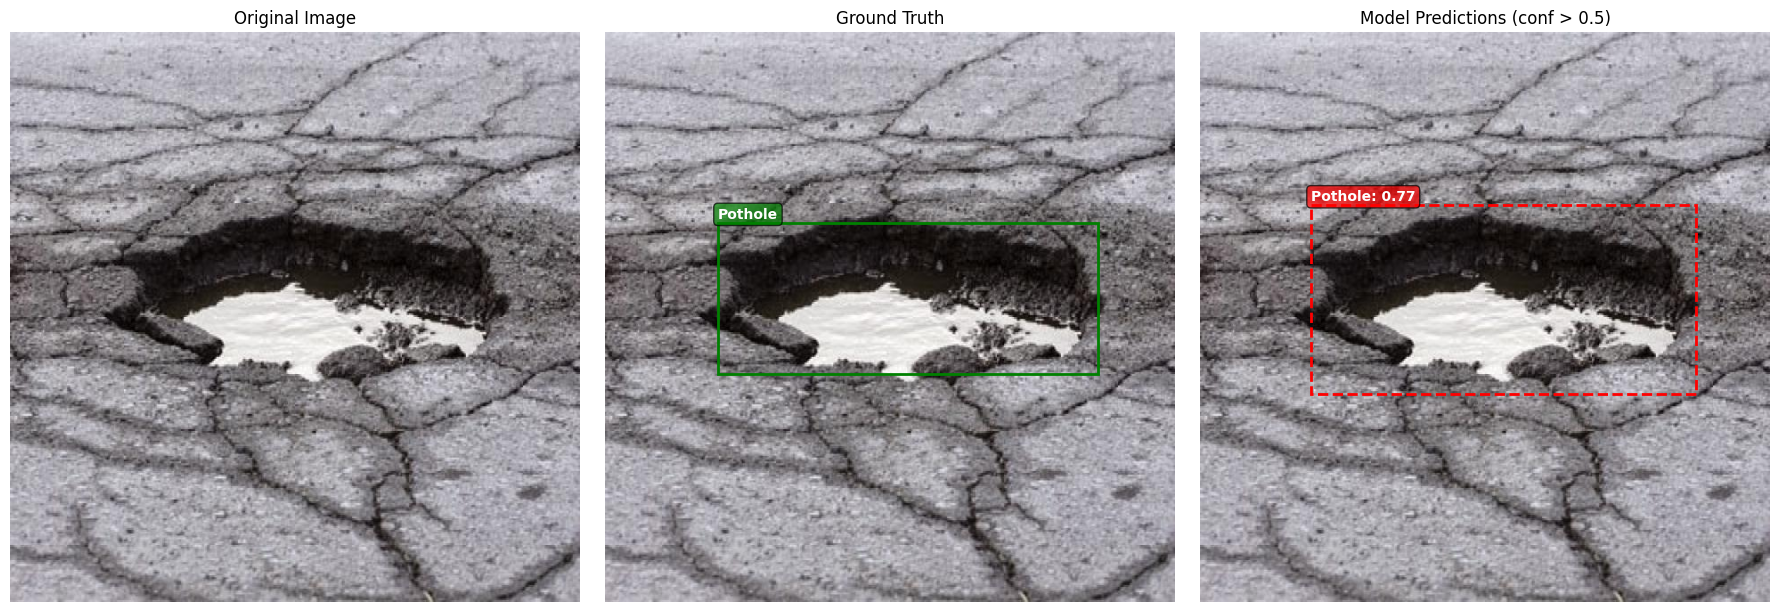

Image: 126_jpg.rf.0b09be9cee98583c87d95a68a8d8655e.jpg
Detected: 1 potholes
Avg confidence: 0.773
Ground truth: 1 potholes
Detection rate: 1/1 potholes

TRY DIFFERENT THRESHOLDS:
To test with different thresholds, run:
=> metrics = evaluate_model_performance(inference_model, conf_threshold=0.3, iou_threshold=0.5)
=> metrics = evaluate_model_performance(inference_model, conf_threshold=0.7, iou_threshold=0.3)


In [26]:
def evaluate_model_performance(model, conf_threshold=0.5, iou_threshold=0.5):
    """
    Evaluate model performance on entire test set using IoU and Dice metrics
    """
    print(f"\nCOMPREHENSIVE MODEL EVALUATION")
    print("=" * 50)
    print(f"Configuration:")
    print(f"  => Confidence threshold: {conf_threshold}")
    print(f"  => IoU threshold: {iou_threshold}")
    print("=" * 50)

    # Get all test images
    test_images = glob.glob(f'{DATASET_ROOT}/test/images/*.jpg')
    if not test_images:
        print("No test images found!")
        return None

    print(f"Evaluating on {len(test_images)} test images...")

    # Metrics storage
    all_ious = []
    all_dice = []
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Per-image metrics
    image_results = []

    for img_path in test_images:
        # Load image dimensions
        image = Image.open(img_path)
        img_width, img_height = image.size

        # Get predictions
        predictions = predict_potholes(model, img_path, conf_threshold)

        # Get ground truth
        label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
        labels = load_yolo_labels(label_path)

        # Convert ground truth to bbox format
        gt_boxes = []
        for label in labels:
            x_center = label['x_center'] * img_width
            y_center = label['y_center'] * img_height
            width = label['width'] * img_width
            height = label['height'] * img_height

            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x1 + width
            y2 = y1 + height

            gt_boxes.append({
                'bbox': [x1, y1, x2, y2],
                'label': 'pothole'
            })

        # Match predictions to ground truth
        matches, unmatched_preds, unmatched_gts = match_predictions_to_ground_truth(
            predictions, gt_boxes, iou_threshold
        )

        # Calculate metrics for this image
        image_ious = []
        image_dice_scores = []

        for pred_idx, gt_idx, iou in matches:
            # Calculate Dice for matched pairs
            dice = calculate_dice(predictions[pred_idx]['bbox'], gt_boxes[gt_idx]['bbox'])

            image_ious.append(iou)
            image_dice_scores.append(dice)
            all_ious.append(iou)
            all_dice.append(dice)
            true_positives += 1

        false_positives += len(unmatched_preds)
        false_negatives += len(unmatched_gts)

        # Store per-image results
        image_results.append({
            'path': img_path,
            'num_predictions': len(predictions),
            'num_ground_truth': len(gt_boxes),
            'true_positives': len(matches),
            'false_positives': len(unmatched_preds),
            'false_negatives': len(unmatched_gts),
            'avg_iou': np.mean(image_ious) if image_ious else 0,
            'avg_dice': np.mean(image_dice_scores) if image_dice_scores else 0
        })

    # Calculate overall metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Display results
    print(f"\nOVERALL PERFORMANCE METRICS")
    print("=" * 50)
    print(f"Detection Metrics:")
    print(f"  => True Positives:  {true_positives}")
    print(f"  => False Positives: {false_positives}")
    print(f"  => False Negatives: {false_negatives}")
    print(f"  => Precision:       {precision:.3f}")
    print(f"  => Recall:          {recall:.3f}")
    print(f"  => F1 Score:        {f1_score:.3f}")

    print(f"\nOverlap Metrics (for matched detections):")
    if all_ious:
        print(f"  => Mean IoU (Jaccard):  {np.mean(all_ious):.3f} ± {np.std(all_ious):.3f}")
        print(f"  => Mean Dice:           {np.mean(all_dice):.3f} ± {np.std(all_dice):.3f}")
        print(f"  => Median IoU:          {np.median(all_ious):.3f}")
        print(f"  => Median Dice:         {np.median(all_dice):.3f}")
    else:
        print(f"  => No matched detections found!")

    # Show distribution of IoU scores
    if all_ious:
        print(f"\nIoU Distribution:")
        print(f"  => IoU ≥ 0.9:  {sum(1 for iou in all_ious if iou >= 0.9)} ({100*sum(1 for iou in all_ious if iou >= 0.9)/len(all_ious):.1f}%)")
        print(f"  => IoU ≥ 0.75: {sum(1 for iou in all_ious if iou >= 0.75)} ({100*sum(1 for iou in all_ious if iou >= 0.75)/len(all_ious):.1f}%)")
        print(f"  => IoU ≥ 0.5:  {sum(1 for iou in all_ious if iou >= 0.5)} ({100*sum(1 for iou in all_ious if iou >= 0.5)/len(all_ious):.1f}%)")

    # Find best and worst performing images
    image_results.sort(key=lambda x: x['avg_iou'], reverse=True)

    print(f"\nBest Performing Images (by IoU):")
    for i in range(min(3, len(image_results))):
        result = image_results[i]
        if result['avg_iou'] > 0:
            print(f"  {i+1}. {os.path.basename(result['path'])}: IoU={result['avg_iou']:.3f}, Dice={result['avg_dice']:.3f}")

    print(f"\nWorst Performing Images (by IoU):")
    worst_with_detections = [r for r in image_results if r['num_ground_truth'] > 0]
    worst_with_detections.sort(key=lambda x: x['avg_iou'])
    for i in range(min(3, len(worst_with_detections))):
        result = worst_with_detections[i]
        print(f"  {i+1}. {os.path.basename(result['path'])}: IoU={result['avg_iou']:.3f}, FN={result['false_negatives']}, FP={result['false_positives']}")

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_iou': np.mean(all_ious) if all_ious else 0,
        'mean_dice': np.mean(all_dice) if all_dice else 0,
        'all_ious': all_ious,
        'all_dice': all_dice,
        'image_results': image_results
    }

def demo_model_performance(model, num_samples=3):
    """Demonstrate model performance on sample test images with visualizations"""
    print(f"\nVISUAL DEMONSTRATION ON SAMPLE IMAGES")
    print("=" * 45)

    # Get test images
    test_images = glob.glob(f'{DATASET_ROOT}/test/images/*.jpg')
    if not test_images:
        print("No test images found!")
        return

    print(f"Visualizing {min(num_samples, len(test_images))} sample images")

    # Select random samples
    samples = random.sample(test_images, min(num_samples, len(test_images)))

    for i, img_path in enumerate(samples):
        print(f"\n--- Test Sample {i+1} ---")
        visualize_predictions(model, img_path, conf_threshold=0.5, show_ground_truth=True)

# Main execution
print(f"\nPOTHOLE DETECTOR EVALUATION")
print("=" * 40)

if os.path.exists(DATASET_ROOT):
    if 'inference_model' in globals():
        # First run comprehensive evaluation
        metrics = evaluate_model_performance(inference_model, conf_threshold=0.5, iou_threshold=0.5)

        # Then show visual demonstrations
        print("\n" + "="*50)
        demo_model_performance(inference_model, num_samples=1)

        # Option to test with different thresholds
        print(f"\nTRY DIFFERENT THRESHOLDS:")
        print("=" * 40)
        print("To test with different thresholds, run:")
        print("=> metrics = evaluate_model_performance(inference_model, conf_threshold=0.3, iou_threshold=0.5)")
        print("=> metrics = evaluate_model_performance(inference_model, conf_threshold=0.7, iou_threshold=0.3)")

    else:
        print("Model not loaded yet. Run Cell 7 after training completes.")
else:
    print(f"Dataset not found at: {DATASET_ROOT}")

# CELL 9: Final Summary and Next Steps

In [30]:
def show_summary():
    """Show final summary and next steps"""
    print(f"\nCONGRATULATIONS!")
    print("=" * 25)
    print("You have successfully:")
    print("=> Analyzed a custom pothole detection dataset")
    print("=> Visualized training data with annotations")
    print("=> Set up YOLOv8 for custom training")
    print("=> Demonstrated object detection inference")
    print("=> Compared ground truth vs predictions")

    print(f"\nNEXT STEPS FOR STUDENTS:")
    print("1. Try training with different epochs (10, 30, 50)")
    print("2. Experiment with different YOLOv8 model sizes")
    print("3. Test different confidence thresholds")
    print("4. Upload your own pothole images for testing")
    print("5. Build a simple web app using the trained model")

    print(f"\nREAL-WORLD APPLICATIONS:")
    print("Automatic form processing")
    print("Receipt and invoice digitization")
    print("License plate recognition")
    print("Scientific data extraction")
    print("Quality control in manufacturing")

    print(f"\nLEARNING OBJECTIVES ACHIEVED:")
    print("=> Understanding of object detection datasets")
    print("=> YOLO architecture and training process")
    print("=> Transfer learning concepts")
    print("=> Model evaluation and metrics")
    print("=> Computer vision pipeline development")

show_summary()

print(f"\nUSEFUL RESOURCES:")
print("=> Ultralytics Documentation: https://docs.ultralytics.com")
print("=> YOLOv8 GitHub: https://github.com/ultralytics/ultralytics")
print("=> Roboflow Universe: https://universe.roboflow.com")
print("=> Computer Vision Course: https://course.fast.ai")

print(f"\n Happy Learning! ")


CONGRATULATIONS!
You have successfully:
=> Analyzed a custom pothole detection dataset
=> Visualized training data with annotations
=> Set up YOLOv8 for custom training
=> Demonstrated object detection inference
=> Compared ground truth vs predictions

NEXT STEPS FOR STUDENTS:
1. Try training with different epochs (10, 30, 50)
2. Experiment with different YOLOv8 model sizes
3. Test different confidence thresholds
4. Upload your own pothole images for testing
5. Build a simple web app using the trained model

REAL-WORLD APPLICATIONS:
Automatic form processing
Receipt and invoice digitization
License plate recognition
Scientific data extraction
Quality control in manufacturing

LEARNING OBJECTIVES ACHIEVED:
=> Understanding of object detection datasets
=> YOLO architecture and training process
=> Transfer learning concepts
=> Model evaluation and metrics
=> Computer vision pipeline development

USEFUL RESOURCES:
=> Ultralytics Documentation: https://docs.ultralytics.com
=> YOLOv8 GitHub